In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import scipy
from scipy import spatial

In [118]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80

### Hyperparameters initialisation:

In [3]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [4]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [5]:
#number of rbf centers
num_phi_rbf = 100

#sigma of the radial basis function
phi_rbf_sigma =5.0 

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20

In [6]:
#dimension of the latent variable z that embeds beta
z_dim = 25

In [7]:
# Gives the numbers of betas to learn
num_training_funcs = 1000

In [8]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
K = 80

In [9]:
#the encoder and the decoder parts each have 3 layers
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

In [10]:
s_lims =[-5.0, 5.0]

In [11]:
#Define the exponential kernel: l is the lengthscale parameter. 
def square_exponential_kernel(t_i, t_j, l, sigma_f):    
    dist = scipy.spatial.distance.cdist(t_i, t_j, 'sqeuclidean')
    
    return sigma_f**2 * np.exp(-0.5 / l**2 * dist)

In [12]:
lengthscale=1.0
sigma_f=1.0

In [13]:
def generate_GP_dataset_with_kernel(lengthscale, sigma_f):
    
    locations_append=[]
    GP_samples_append=[]
    
    for fct_id in range(num_training_funcs):
        #print("fct_id:")
        #print(fct_id)
        
        locations = np.random.uniform(s_lims[0], s_lims[1],size=(K,1))  
        #compute correlation matrix between those K locations
        cov = square_exponential_kernel(locations, locations, lengthscale, sigma_f)
        #cov.shape
        
        mu = np.zeros(locations.shape)
        
        GP_sample = np.random.multivariate_normal(mu.ravel(), cov, 1)        
            
        locations_append.append(locations)
        GP_samples_append.append(GP_sample)
        
    
    return np.array(locations_append), np.array(GP_samples_append)
    

In [14]:
dataset_locations, dataset_GP=generate_GP_dataset_with_kernel(lengthscale, sigma_f)

In [15]:
dataset_locations.shape

(1000, 80, 1)

In [16]:
dataset_GP.shape

(1000, 1, 80)

In [17]:
dataset_loc_training=dataset_locations[:1000,:,:]
dataset_GP_training=dataset_GP[:1000,:,:]

In [18]:
#dataset_loc_test=dataset_locations[1500:,:,:]
#dataset_GP_test=dataset_GP[1500:,:,:]

In [19]:
#dataset_loc_training.shape
dataset_GP_training.shape

(1000, 1, 80)

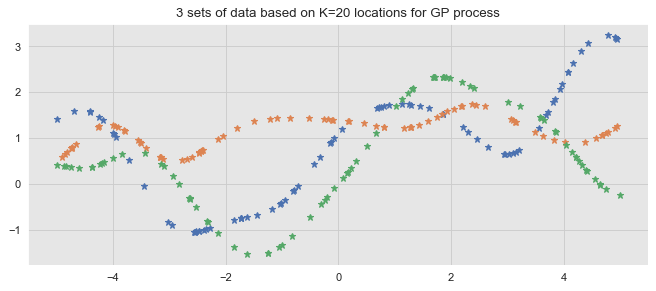

In [20]:
for i in range(3):
    plt.plot(dataset_locations[i,:,0],dataset_GP[i,0,:], "*")
plt.title("3 sets of data based on K=20 locations for GP process")
plt.show()

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
    
        self.phi_rbf_centers = nn.Parameter(torch.tensor(
            np.random.uniform(s_lims[0], s_lims[1],
            size=(num_phi_rbf, input_dim))))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, encoder_h_dim_1)
        self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, decoder_h_dim_1)
        self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-0.5, 0.5, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)


    def Phi(self, input):
        input_expand = torch.unsqueeze(input, 1)
    
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)

        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = F.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5
     

    def encoder(self, input):        
        # input (batch x beta_dim) output ((batch x z_dim), (batch x z_dim))
        M1 = F.relu(self.encoder_nn_1(input))
        M2 = F.relu(self.encoder_nn_2(M1))
        M3 = F.relu(self.encoder_nn_3(M2))
        M4 = self.encoder_nn_4(M3)
        z_mean = M4[:, 0:z_dim]
        z_std = torch.exp(M4[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        # input (batch x z_dim) output (batch x beta_dim)
        M1 = F.relu(self.decoder_nn_1(input))
        M2 = F.relu(self.decoder_nn_2(M1))
        M3 = F.relu(self.decoder_nn_3(M2))
        M4 = self.decoder_nn_4(M3)
        return M4
    
    

    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
        
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x): 
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))       
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())         
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

    
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)       
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        return loss_term_3       
        

   
    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]

        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)

        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2

     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),
            dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    # Compute decoded GP values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)       
        beta_hat = self.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat
   

    # This function returns decoded values of x when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):               
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()        
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

In [22]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=512, bias=True)
  (encoder_nn_2): Linear(in_features=512, out_features=512, bias=True)
  (encoder_nn_3): Linear(in_features=512, out_features=128, bias=True)
  (encoder_nn_4): Linear(in_features=128, out_features=50, bias=True)
  (decoder_nn_1): Linear(in_features=25, out_features=128, bias=True)
  (decoder_nn_2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_3): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_4): Linear(in_features=128, out_features=100, bias=True)
)

In [23]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 1
current_max = 1000
interval = 3

total_nbr_epochs=300

In [24]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [25]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [26]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_loc_training[function_id])
        x_vals = torch.tensor(dataset_GP_training[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+10, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0
L1 2.3198889030109955 L2 2.150703570859657 L3 0.0037710505623706763 Loss 4.474363524433022 num funcs 11
epoch id: 1


/Users/tresniaberah/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L1 0.9516894367011058 L2 1.181495239299856 L3 0.006232197536448566 Loss 2.13941687353741 num funcs 11
epoch id: 2
L1 0.773532856149968 L2 1.0049886186545347 L3 0.007026005595028492 Loss 1.7855474803995313 num funcs 11
epoch id: 3
L1 0.6784150818398509 L2 0.9258553675282222 L3 0.006490586849636828 Loss 1.6107610362177098 num funcs 21
epoch id: 4
L1 1.106306249999849 L2 0.8311189529375083 L3 0.004968991191225881 Loss 1.9423941941285832 num funcs 21
epoch id: 5
L1 0.6878748526328133 L2 0.8706253223281208 L3 0.0038517373654286804 Loss 1.562351912326363 num funcs 21
epoch id: 6
L1 0.5928172554384995 L2 0.8299610279438228 L3 0.010577154414660747 Loss 1.433355437796983 num funcs 31
epoch id: 7
L1 0.9923677710583116 L2 0.9537846487068413 L3 0.026067923866345363 Loss 1.9722203436314985 num funcs 31
epoch id: 8
L1 0.6439268614070034 L2 0.970622036155436 L3 0.03298154703846058 Loss 1.6475304446008996 num funcs 31
epoch id: 9
L1 0.5508512081942467 L2 0.9250411391218918 L3 0.05496471734193834 Loss 

L1 0.1149193562475286 L2 0.7205895524064304 L3 0.06741978385188747 Loss 0.9029286925058466 num funcs 241
epoch id: 72
L1 0.09159639149752566 L2 0.7141475419206226 L3 0.08098531992477474 Loss 0.886729253342923 num funcs 251
epoch id: 73
L1 0.12374085369209704 L2 0.7346204194878551 L3 0.08459964140444493 Loss 0.9429609145843972 num funcs 251
epoch id: 74
L1 0.1127901901435645 L2 0.7364604738160038 L3 0.08334975488384853 Loss 0.9326004188434168 num funcs 251
epoch id: 75
L1 0.08751940241723254 L2 0.7131620086984033 L3 0.0806308032431657 Loss 0.8813122143588017 num funcs 261
epoch id: 76
L1 0.12847519958250475 L2 0.7508720741930717 L3 0.0728877062963324 Loss 0.952234980071909 num funcs 261
epoch id: 77
L1 0.10667619282662805 L2 0.7304259659760846 L3 0.07368812973399166 Loss 0.9107902885367043 num funcs 261
epoch id: 78
L1 0.0821675883921877 L2 0.7346975697756718 L3 0.07265064422433078 Loss 0.8895158023921903 num funcs 271
epoch id: 79
L1 0.11641387986175375 L2 0.7392463931545765 L3 0.07359

L1 0.06398815104747618 L2 0.5639791792982 L3 0.1252722449800506 Loss 0.7532395753257269 num funcs 471
epoch id: 141
L1 0.048208002149020886 L2 0.5487006350682647 L3 0.12727652559918007 Loss 0.7241851628164657 num funcs 481
epoch id: 142
L1 0.06680430452804541 L2 0.5565743404156615 L3 0.12614385804491604 Loss 0.749522502988623 num funcs 481
epoch id: 143
L1 0.05622232065043729 L2 0.5470141825098706 L3 0.11792767100967783 Loss 0.7211641741699856 num funcs 481
epoch id: 144
L1 0.042588419662983504 L2 0.5463850064866576 L3 0.12049503257199345 Loss 0.7094684587216346 num funcs 491
epoch id: 145
L1 0.0684528448722151 L2 0.5688230828797143 L3 0.12453702532429665 Loss 0.761812953076226 num funcs 491
epoch id: 146
L1 0.06121415245332278 L2 0.5671425920777566 L3 0.1245470601879007 Loss 0.7529038047189802 num funcs 491
epoch id: 147
L1 0.04921912425813999 L2 0.5505774434931856 L3 0.12834661138669146 Loss 0.7281431791380171 num funcs 501
epoch id: 148
L1 0.06778974174182255 L2 0.557901544922544 L3

L1 0.04253205013953104 L2 0.5325196987197728 L3 0.13219982651735532 Loss 0.7072515753766592 num funcs 701
epoch id: 210
L1 0.036003696176842265 L2 0.5289589828888878 L3 0.13087705193109975 Loss 0.6958397309968298 num funcs 711
epoch id: 211
L1 0.052595237538049414 L2 0.5362223864168097 L3 0.1307462825257005 Loss 0.7195639064805596 num funcs 711
epoch id: 212
L1 0.046085109309951265 L2 0.532124375263216 L3 0.13201403803960618 Loss 0.7102235226127734 num funcs 711
epoch id: 213
L1 0.03752338141843567 L2 0.5309993473004315 L3 0.1339005825566625 Loss 0.7024233112755296 num funcs 721
epoch id: 214
L1 0.049762068106878644 L2 0.5302054934238112 L3 0.13346072868480188 Loss 0.7134282902154918 num funcs 721
epoch id: 215
L1 0.04285029675080952 L2 0.5272532299216421 L3 0.1347367929616202 Loss 0.7048403196340719 num funcs 721
epoch id: 216
L1 0.03476721704091546 L2 0.5194911903937546 L3 0.1349629916870013 Loss 0.6892213991216712 num funcs 731
epoch id: 217
L1 0.05267561301116625 L2 0.5326173971044

L1 0.03936705693388636 L2 0.5319461222221903 L3 0.14180900946411762 Loss 0.7131221886201943 num funcs 931
epoch id: 279
L1 0.033475948618246425 L2 0.5271156008139576 L3 0.13838092788680784 Loss 0.6989724773190119 num funcs 941
epoch id: 280
L1 0.04322959017237447 L2 0.5303977016824234 L3 0.1378222770608945 Loss 0.7114495689156926 num funcs 941
epoch id: 281
L1 0.037309215336582484 L2 0.5278282229661991 L3 0.13983096937118908 Loss 0.7049684076739707 num funcs 941
epoch id: 282
L1 0.03069889451239127 L2 0.5198603732639441 L3 0.14013387821292986 Loss 0.6906931459892652 num funcs 951
epoch id: 283
L1 0.041290775593147186 L2 0.5230586650017595 L3 0.13685249816833966 Loss 0.7012019387632462 num funcs 951
epoch id: 284
L1 0.03497107849821277 L2 0.5268991986647575 L3 0.13958381646284865 Loss 0.7014540936258189 num funcs 951
epoch id: 285
L1 0.029666237423975294 L2 0.5228110270223001 L3 0.14134203422359118 Loss 0.6938192986698666 num funcs 961
epoch id: 286
L1 0.04047711731584004 L2 0.528857968

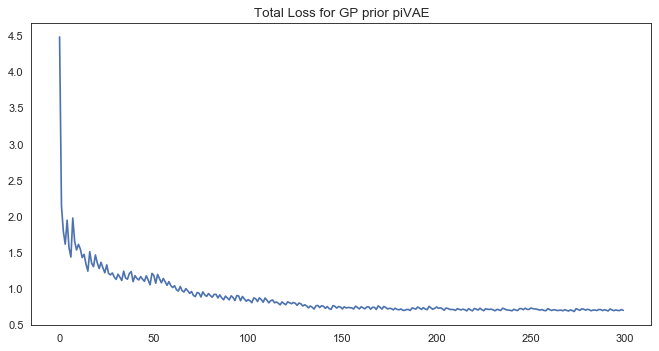

In [107]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for GP prior piVAE" )
plt.show()

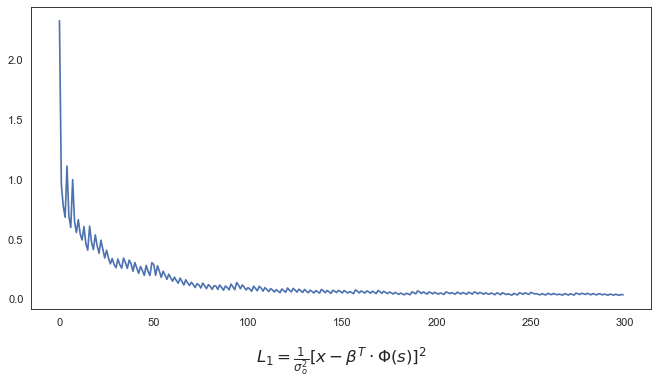

In [122]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma_o^2}[x-\beta^T\cdot\Phi(s)]^2}$', fontsize=15,y=-0.2)
plt.show()

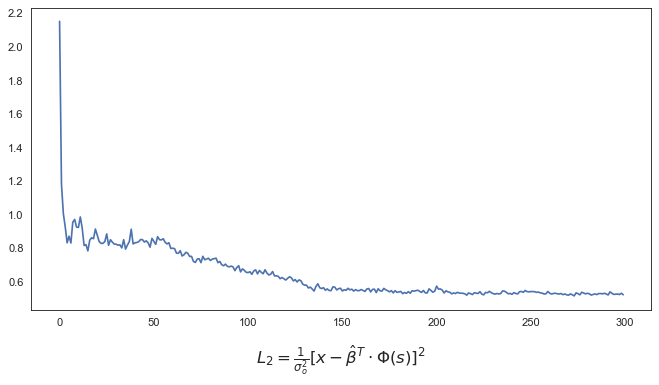

In [123]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma_o^2}[x-\hat\beta^T\cdot\Phi(s)]^2}$', fontsize=15,y=-0.2)
plt.show()
plt.show()

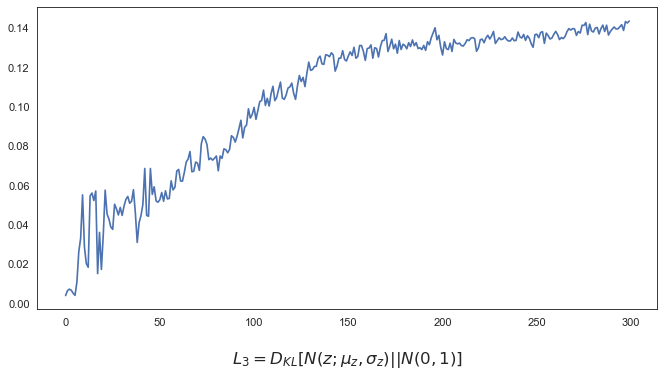

In [124]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$', fontsize=15,y=-0.2)
plt.show()
plt.show()

### Generate GP samples from piVAE using $z \sim N(0,1):$

In [31]:
num_piVAE_samples=5

In [32]:
test_pts_for_plot_tensor = torch.arange(-5., 5., 0.05).double() 
test_pts_for_plot_tensor.shape    

torch.Size([200])

In [33]:
test_pts_for_plot_np = np.arange(-5., 5., 0.05)
test_pts_for_plot_np.shape    

(200,)

In [34]:
piVAE_samples_tensor = pivae_model.generate_x_samples_from_pivae(
                                test_pts_for_plot_tensor.unsqueeze(1),5)

In [35]:
piVAE_samples_np = np.array(piVAE_samples_tensor.detach().numpy())

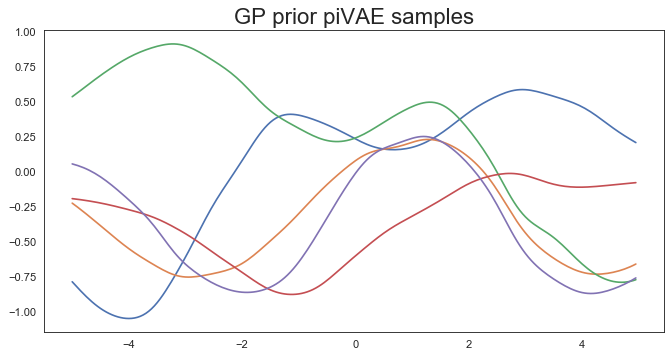

In [114]:
for i in range(piVAE_samples_np.shape[0]):
    plt.plot(test_pts_for_plot_tensor.detach().cpu().numpy(), piVAE_samples_np[i, :])
plt.title("GP prior piVAE samples", fontsize=20)
plt.show()

In [37]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_x_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [38]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [39]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        
        if(z_sample %1000==0):
            print("sample_id",z_sample)
            
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [40]:
ls=1.0
sigma_f=1.0

def ground_truth_GP_function(locations):

    cov = square_exponential_kernel(locations, locations, ls, sigma_f)
    mu = np.zeros(locations.shape)
        
    GP_sample = np.random.multivariate_normal(mu.ravel(), cov, 1) 
    return GP_sample.T



In summary what needs doing is the following: create a long series of test points of size say 1000. On these points compute x-values of an OU process. Store these 2 series into a dataframe. 
Select 100 points from this df: 100 s locations and their corresponding x values. 
Run MCMC on these 100 points and plot against the true value. 

Then select another 20 points from this same dataframe but which has not been used to run the first posterior. 
Run MCMC to get posterior om these new 20 points. 
Compare the value of the posterior st these new points with their true v alue from the dataframe. 

In [129]:
s_star_np=np.arange(-5.,5,0.01)
s_star_np.shape

(1000,)

In [130]:
x_star_np=ground_truth_GP_function(np.expand_dims(s_star_np,1))
x_star_np.shape

(1000, 1)

In [131]:
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
df.shape

(1000, 3)

In [132]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i+50]
    x_obs[i]=df['x_star'][k*i+50]
s_obs.shape

100


(10,)

In [133]:
#add noise to ground truth
sigma_noise=0.1
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

nbr observations: 10


Text(0.5, 1.0, 'Ground truth OU prior and 10 observations')

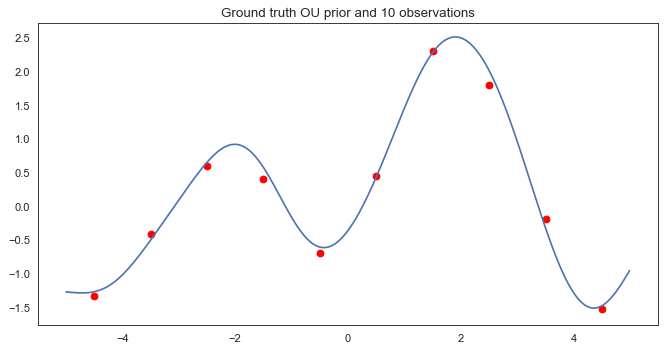

In [134]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')
print("nbr observations:", len(y_obs))
length=len(y_obs)
plt.title('Ground truth OU prior and 10 observations')
#plt.show()

In [135]:
z = torch.ones((z_dim,)).double()

In [136]:
#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=50000
MH_proposal_sigma=0.5
obs_sigma=1.5

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
sample_id 10000
sample_id 11000
sample_id 12000
sample_id 13000
sample_id 14000
sample_id 15000
sample_id 16000
sample_id 17000
sample_id 18000
sample_id 19000
sample_id 20000
sample_id 21000
sample_id 22000
sample_id 23000
sample_id 24000
sample_id 25000
sample_id 26000
sample_id 27000
sample_id 28000
sample_id 29000
sample_id 30000
sample_id 31000
sample_id 32000
sample_id 33000
sample_id 34000
sample_id 35000
sample_id 36000
sample_id 37000
sample_id 38000
sample_id 39000
sample_id 40000
sample_id 41000
sample_id 42000
sample_id 43000
sample_id 44000
sample_id 45000
sample_id 46000
sample_id 47000
sample_id 48000
sample_id 49000
mean acceptance prob tensor(0.5079, dtype=torch.float64)


In [139]:
mcmc_selected_samples_run1 = mcmc_samples[10000::500,:]

In [140]:
mcmc_selected_samples_run1.shape

torch.Size([80, 25])

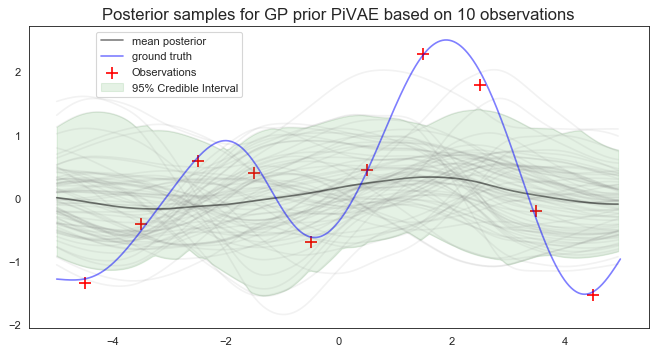

In [164]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.5, color='k', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="red", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(bbox_to_anchor=(0.1, 1))
plt.title("Posterior samples for GP prior PiVAE based on 10 observations" , fontsize=15)
plt.show()

In [142]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_new=np.zeros(nbr_new_star)
x_obs_new=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_new[i]=df['s_star'][180*i+50]
    x_obs_new[i]=df['x_star'][180*i+50]
x_obs_new.shape

(5,)

Text(0.5, 1.0, 'Ground truth GP prior')

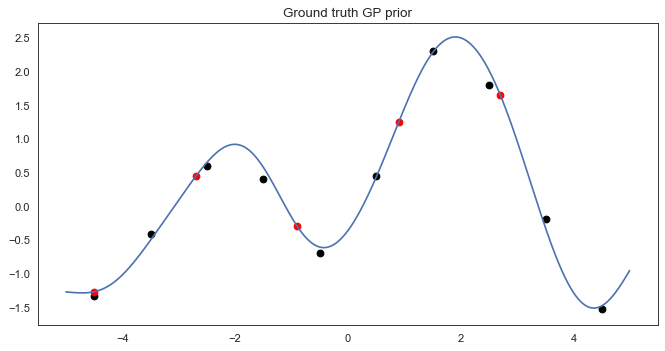

In [143]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_new, x_obs_new,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth GP prior')
#plt.show()

In [151]:
#now we need to compute the posterior at these new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=20000
mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_new).unsqueeze(1), torch.tensor(x_obs_new))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
sample_id 10000
sample_id 11000
sample_id 12000
sample_id 13000
sample_id 14000
sample_id 15000
sample_id 16000
sample_id 17000
sample_id 18000
sample_id 19000
mean acceptance prob tensor(0.5269, dtype=torch.float64)


In [157]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::100,:]

In [158]:
mcmc_selected_samples_run2.shape

torch.Size([190, 25])

In [159]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [160]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_new).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

(5,)

In [161]:
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_new)**2/nbr_new_star))
RMSE

0.9713995498890905

In [62]:
def check_beta(model, id):
    
    test_points = torch.arange(-5, 5, 0.1).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_loc_training[id].reshape(K), dataset_GP_training[id].reshape(K))
    plt.title("Reconstruction of training data")
    plt.show()

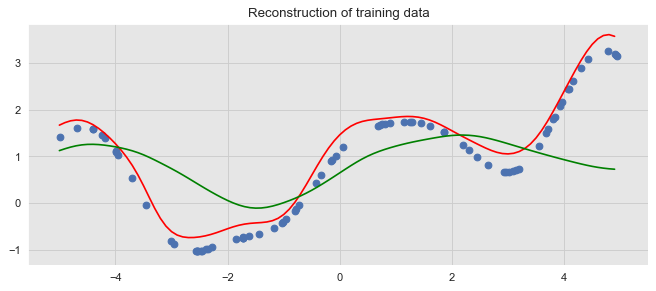

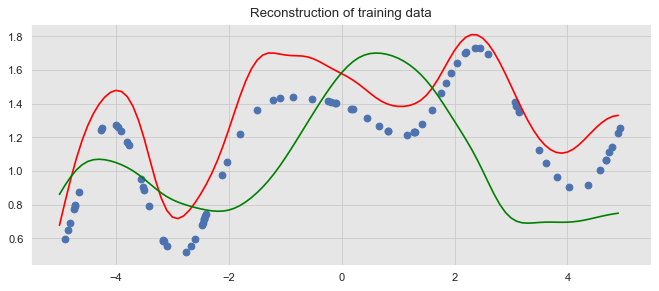

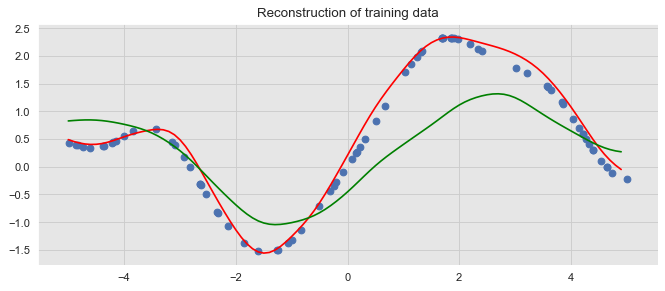

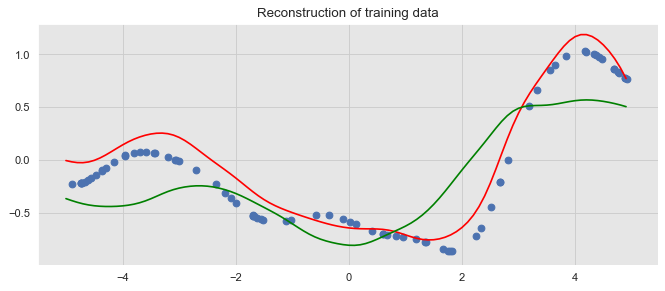

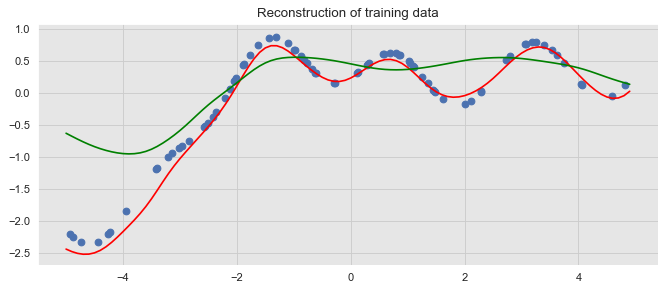

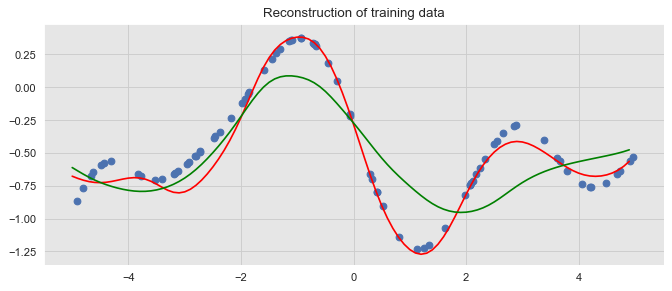

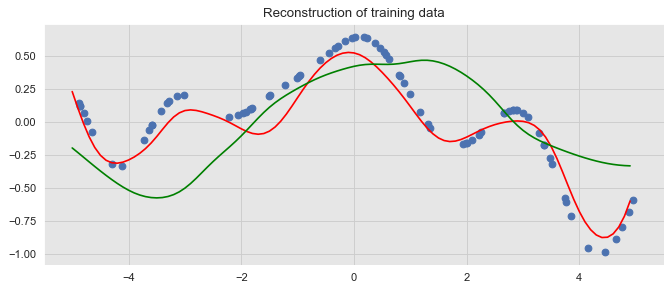

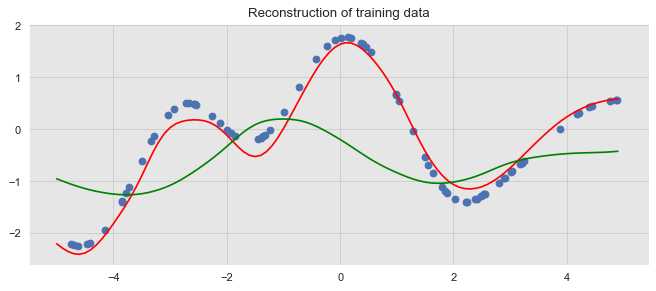

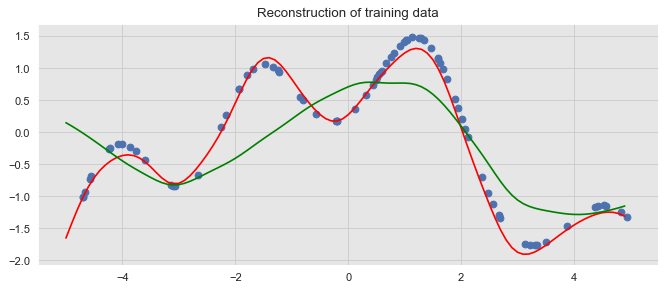

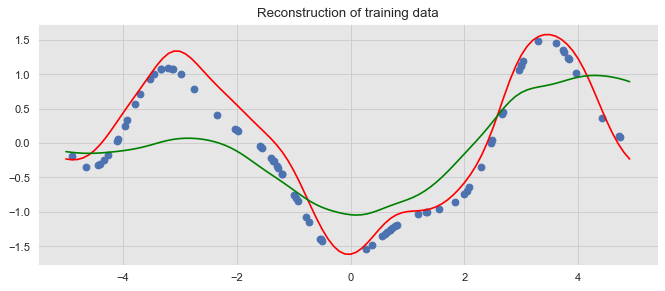

In [63]:
# ------ Check reconstructions of training data -------
for i in range(10):
    check_beta(pivae_model, i)

#%%